### Basic importing of modules, clever loop for importing all raw data frames efficiently

TO DO: FIX ORDER OF PLOTTING

In [191]:
import glob
import os
import pandas as pd

folder_paths = ["Controls", "LC", "ME"]

# Dictionaries to hold DataFrames and headers for each folder
all_dfs = {}
all_headers = {}

for path in folder_paths:
    csv_files = glob.glob(os.path.join(path, '*.xlsx'))
    print(csv_files)
    # Read data without headers, skipping the first 3 rows
    dfs = [pd.read_excel(file, header=None, skiprows=3) for file in csv_files]
    
    # Read the header row separately (the row just before the data starts, so skiprows=2)
    headers = [pd.read_excel(file, nrows=1, header=None) for file in csv_files]
    
    # Assign the header row to each DataFrame
    for df, header in zip(dfs, headers):
        df.columns = header.iloc[0]
        
    # Store the DataFrames and headers in the dictionaries
    all_dfs[path] = dfs
    all_headers[path] = headers

# 25 seconds

['Controls\\P110061.xlsx', 'Controls\\P110090.xlsx', 'Controls\\P110096.xlsx', 'Controls\\P110097.xlsx', 'Controls\\P110098.xlsx', 'Controls\\P110099.xlsx', 'Controls\\P110101.xlsx', 'Controls\\P110102.xlsx', 'Controls\\P110103.xlsx', 'Controls\\P110104.xlsx', 'Controls\\P110106.xlsx', 'Controls\\P110107.xlsx', 'Controls\\P110109.xlsx', 'Controls\\P110110.xlsx', 'Controls\\P110112.xlsx', 'Controls\\P110114.xlsx', 'Controls\\P110115.xlsx', 'Controls\\P110126_P110126_CPET.xlsx', 'Controls\\P110132_P110132_CPET.xlsx', 'Controls\\P110139_P110139_CPET.xlsx', 'Controls\\P110140_110140_CPET.xlsx', 'Controls\\P110148_P110148_CPET.xlsx', 'Controls\\P110149_P110149_CPET.xlsx', 'Controls\\P110150_P110150_CPET.xlsx', 'Controls\\P110151_P110151_CPET.xlsx', 'Controls\\P110152_P110152_CPET.xlsx']
['LC\\P110017.xlsx', 'LC\\P110039.xlsx', 'LC\\P110050.xlsx', 'LC\\P110051.xlsx', 'LC\\P110055.xlsx', 'LC\\P110056.xlsx', 'LC\\P110058.xlsx', 'LC\\P110064.xlsx', 'LC\\P110085.xlsx', 'LC\\P110086.xlsx', 'LC\\P

### Create a copy of the grouped data frame to work with, to avoid having to import all the data frames over and over again

In [192]:
all_dfs_c = {'Controls':[], 'LC':[], 'ME':[]}
groups = ['Controls', 'LC', 'ME']
for group in groups:
    group_list = []
    for df in all_dfs[group]:
        group_list.append(df.copy())
    all_dfs_c[group] = group_list

### Count the amount of dataframes with missing columns_to_keep, and identify missing columns

In [193]:
cols_to_use = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Phase']
count = {col: 0 for col in cols_to_use}
no_count = {col: 0 for col in cols_to_use}
for group_name, group in all_dfs_c.items():
    for df in group:
        for col in cols_to_use:
            if col in df.columns:
                count[col] += 1
            else:
                no_count[col] += 1
print(count)
print(no_count)
for i in no_count:
    if no_count[i] > 0:
        print(i)
        print(no_count[i])

{'t': 63, 'Power': 63, 'HR': 60, 'VE': 63, 'VO2': 63, 'VCO2': 63, 'PetCO2': 63, 'PetO2': 63, 'VO2/Kg': 63, 'VE/VO2': 63, 'VE/VCO2': 63, 'RQ': 63, 'VT': 63, 'Rf': 63, 'Ti': 63, 'Te': 63, 'Phase': 63}
{'t': 0, 'Power': 0, 'HR': 3, 'VE': 0, 'VO2': 0, 'VCO2': 0, 'PetCO2': 0, 'PetO2': 0, 'VO2/Kg': 0, 'VE/VO2': 0, 'VE/VCO2': 0, 'RQ': 0, 'VT': 0, 'Rf': 0, 'Ti': 0, 'Te': 0, 'Phase': 0}
HR
3


### Remove unwanted columns, and subsequently removing NaN's   


In [194]:
for group_name, group in all_dfs_c.items():
    for df in group:
        col_rem_2b = [col for col in df.columns if col not in cols_to_use]
        df.drop(columns = col_rem_2b, inplace = True)

for group_name, group in all_dfs_c.items():
    for df in group:
        df.dropna(inplace=True)
Control = all_dfs_c['Controls']
LC = all_dfs_c['LC']
ME = all_dfs_c['ME']

for groupname, group in all_dfs_c.items():
    for i,df in enumerate(group):
        df['Participant'] = f'{groupname}_{i}'

### Concat all dataframes of a single participant group, and change the column order

In [195]:
Control_df = pd.concat((Control), axis = 0)
LC_df = pd.concat((LC), axis = 0)
ME_df = pd.concat((ME), axis = 0)

col_order = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Participant', 'Phase']
Control_df = Control_df[col_order]
LC_df = LC_df[col_order]
ME_df = ME_df[col_order]

CHANGING DATE STRING TO SECONDS

In [196]:
def hhmmss_to_seconds(hhmmss):
    h, m, s = map(int, hhmmss.split(':'))
    return h * 3600 + m * 60 + s

for df in [Control_df, LC_df, ME_df]:
    df['t'] = df['t'].astype('string')
    df['t'] = df['t'].apply(hhmmss_to_seconds)


### Remove rows where the participant is not exercising (See paper for more information)

In [197]:
import copy
Control_df_edit = copy.deepcopy(Control_df)
ME_df_edit = copy.deepcopy(ME_df)
edit_c = dict(zip(['Controls_' + str(i) for i in range(21,26)], [190, 388, 331, 412, 290]))

edit_ME = dict(zip(['ME_' + str(i) for i in range(22,26)], [318, 332, 350, 238]))
Control_df_edit.reset_index(inplace = True)
ME_df_edit.reset_index(inplace = True)
for edit, df in zip([edit_c, edit_ME], [Control_df_edit, ME_df_edit]):
    to_drop = []
    for participant in edit.keys():
        start_exercise = df.groupby('Participant').head(1).index.tolist()[int(participant[-2:])]
        end_exercise = start_exercise + edit[participant]
        end_trial = df.groupby('Participant').tail(1).index.tolist()[int(participant[-2:])]
        to_drop += list(df.index[end_exercise:end_trial+1])
    df.drop(to_drop, inplace = True)
    df.set_index('index', inplace = True)

##### Fixing Control Data

Text(0.5, 1.0, 'Expiratory Time (Te) after correction')

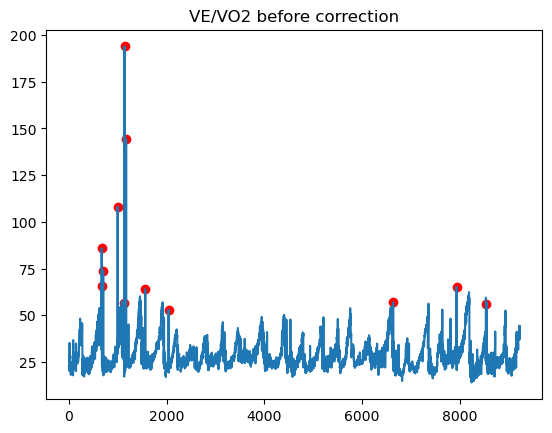

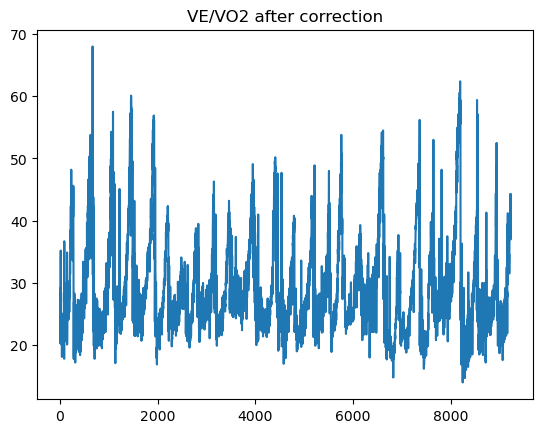

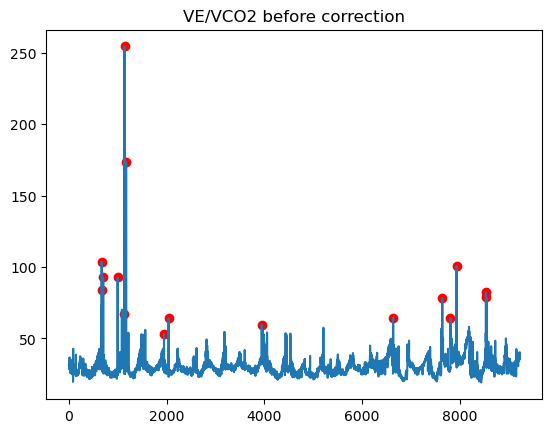

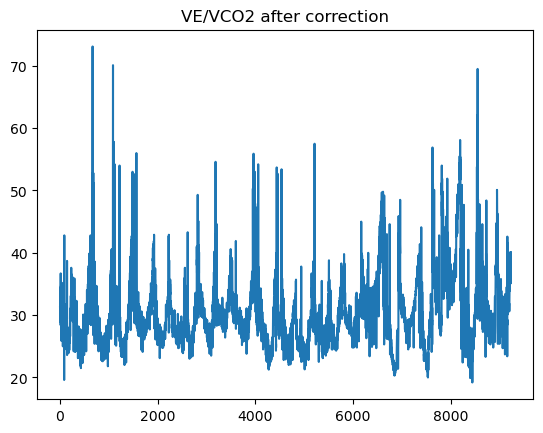

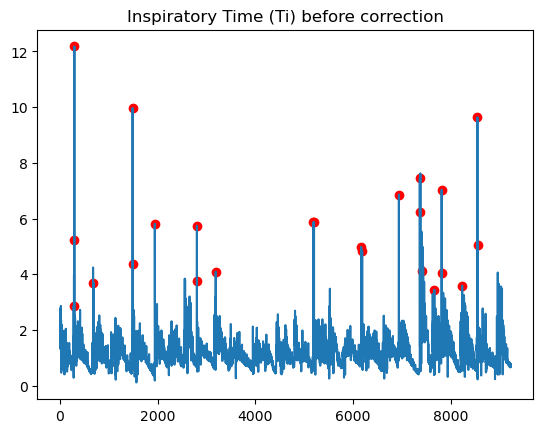

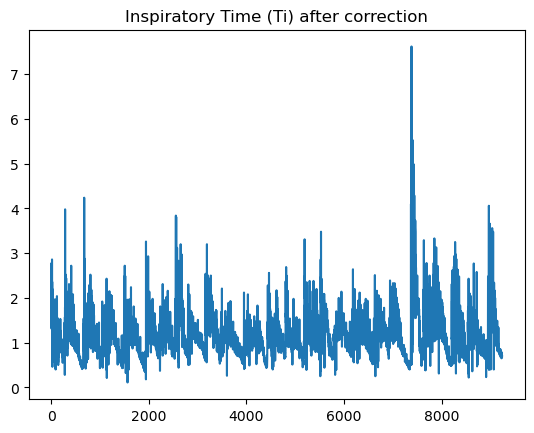

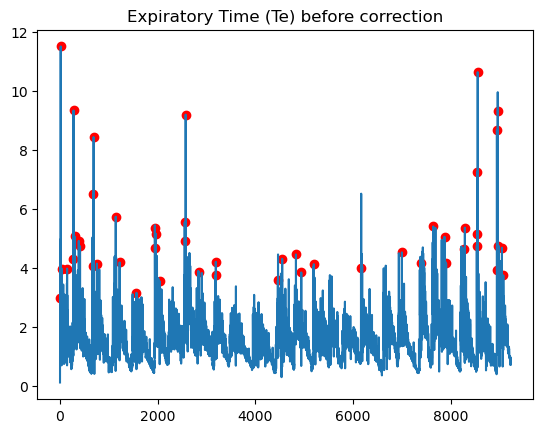

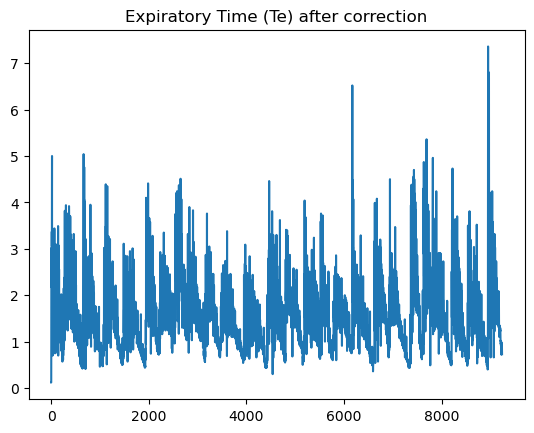

In [198]:
Control_df_edit.reset_index(inplace = True)
Control_df_edit.drop(columns = 'index', inplace = True)
import numpy as np
import matplotlib.pyplot as plt

# Fix HR 
Control_df_edit.loc[666:678, 'HR'] = Control_df_edit.loc[666:678, 'HR'].apply(lambda x: 84 if x < 50 else x)
HR299 = Control_df_edit[Control_df_edit['HR'] < 50].index
if HR299.size > 0:
    Control_df_edit.loc[HR299[0], 'HR'] = np.mean([Control_df_edit['HR'][HR299[0]+1],Control_df_edit['HR'][HR299[0]-1]])

# Fix VE/VO2
def find_large_increments(list, increment):
    result = []
    for i in range(1, len(list)):
        if list[i] - list[i-1] > increment:
            result.append(i)
    return result
vevo2_incr = find_large_increments(Control_df_edit['VE/VO2'], 25)
plt.plot(Control_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, Control_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    Control_df_edit.loc[i, 'VE/VO2'] = Control_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(Control_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')

# Fix VE/VCO2
plt.figure()
vevco2_incr = find_large_increments(Control_df_edit['VE/VCO2'], 25)
plt.plot(Control_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, Control_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    Control_df_edit.loc[i, 'VE/VCO2'] = Control_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(Control_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

# Fix Ti
plt.figure()
plt.plot(Control_df_edit['Ti'])
ti_incr = find_large_increments(Control_df_edit['Ti'], 2.5)
plt.scatter(ti_incr, Control_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    Control_df_edit.loc[i, 'Ti'] = Control_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(Control_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

# Fix Te
te_incr = find_large_increments(Control_df_edit['Te'], 2.5)
plt.figure()
plt.plot(Control_df_edit['Te'])
plt.scatter(te_incr, Control_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    Control_df_edit.loc[i, 'Te'] = Control_df_edit.loc[i-1, 'Te']
te_incr = find_large_increments(Control_df_edit['Te'], 4)
for i in te_incr:
    Control_df_edit.loc[i, 'Te'] = Control_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(Control_df_edit['Te'])
plt.title('Expiratory Time (Te) after correction')

##### Fixing ME data
    

Series([], Name: HR, dtype: float64)
212    0.0
213    0.0
214    0.0
215    0.0
216    0.0
      ... 
342    0.0
343    0.0
344    0.0
345    0.0
346    0.0
Name: HR, Length: 135, dtype: float64
Series([], Name: HR, dtype: float64)
466    0.0
467    0.0
468    0.0
469    0.0
Name: HR, dtype: float64
787      0.0
788      0.0
789      0.0
790      0.0
791      0.0
        ... 
1156    68.0
1157    68.0
1158    68.0
1159    68.0
1160    68.0
Name: HR, Length: 347, dtype: float64
Series([], Name: HR, dtype: float64)
Series([], Name: HR, dtype: float64)
1819    0.0
1820    0.0
1821    0.0
1822    0.0
1823    0.0
       ... 
2066    0.0
2067    0.0
2068    0.0
2069    0.0
2077    0.0
Name: HR, Length: 192, dtype: float64
Series([], Name: HR, dtype: float64)
2392    60.0
2393    60.0
2394    61.0
2395    61.0
2396    61.0
        ... 
2467    69.0
2468    69.0
2469    69.0
2470    68.0
2471    69.0
Name: HR, Length: 63, dtype: float64
Series([], Name: HR, dtype: float64)
Series([], Name: HR

Text(0.5, 1.0, 'Expiratory Time (Te) after correction')

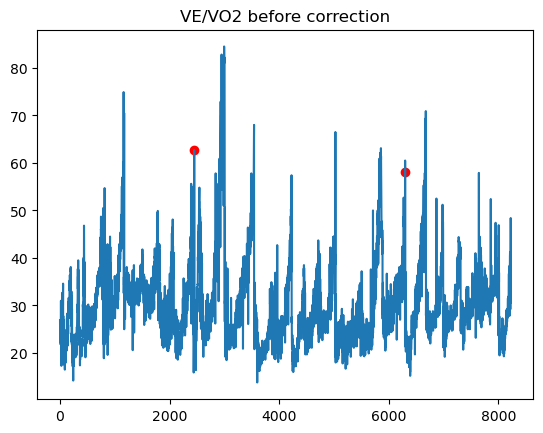

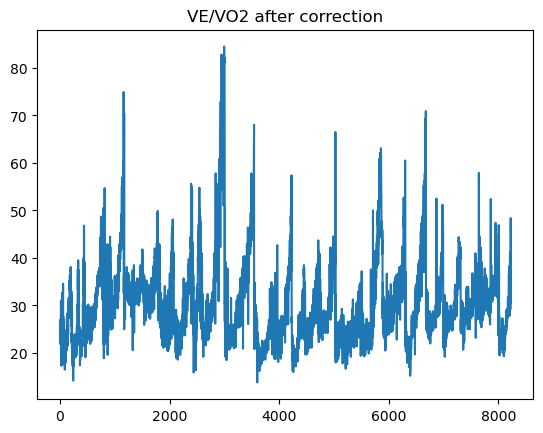

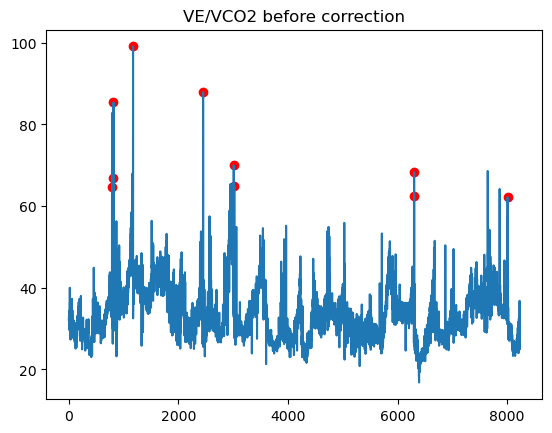

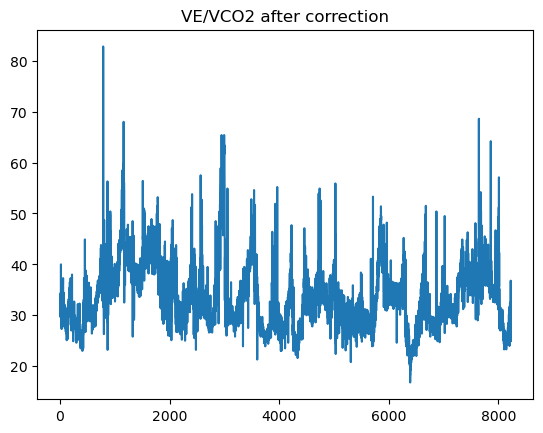

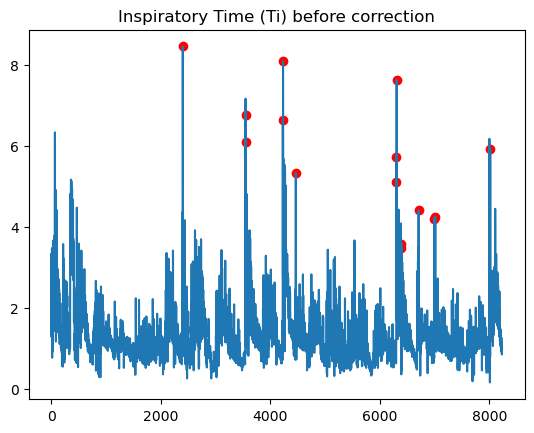

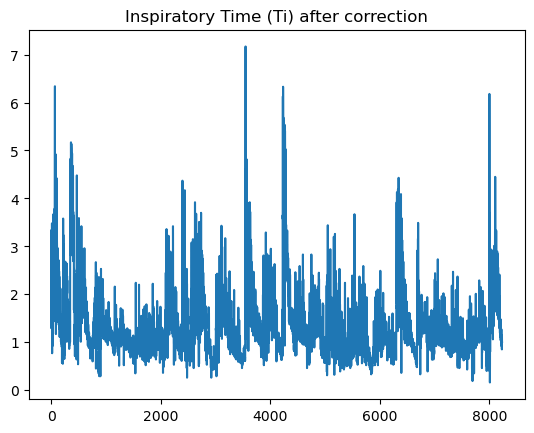

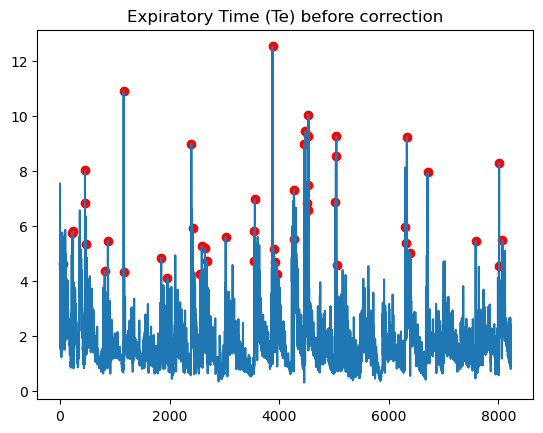

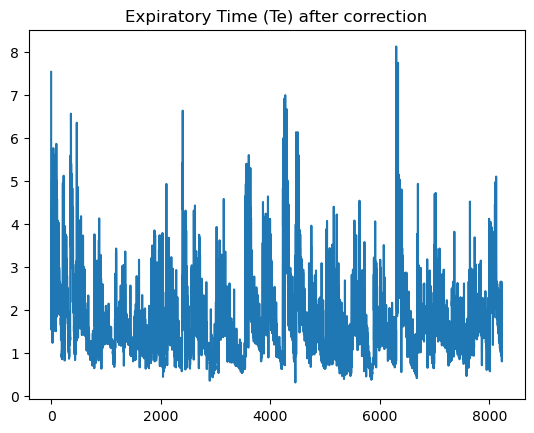

In [199]:
ME_df_edit.reset_index(inplace = True)
ME_df_edit.drop(columns = 'index', inplace = True)

for i in ME_df_edit['Participant'].unique():
    print(ME_df_edit.loc[:2700][(ME_df_edit.loc[:2700]['Participant'] == i) & (ME_df_edit.loc[:2700]['HR'] < 70)]['HR'])
ME_df_edit['HR'].replace(0, np.nan, inplace=True)

# Replace values in 'HR' column that are less than 80 with NaN in the first 2700 rows
ME_df_edit.loc[:2700, 'HR'] = ME_df_edit.loc[:2700, 'HR'].mask(ME_df_edit.loc[:2700, 'HR'] < 80, np.nan)

vevo2_incr = find_large_increments(ME_df_edit['VE/VO2'], 30)
plt.figure()
plt.plot(ME_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, ME_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    ME_df_edit.loc[i, 'VE/VO2'] = ME_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(ME_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')

vevco2_incr = find_large_increments(ME_df_edit['VE/VCO2'], 28)
plt.figure()
plt.plot(ME_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, ME_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    ME_df_edit.loc[i, 'VE/VCO2'] = ME_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(ME_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

ti_incr = find_large_increments(ME_df_edit['Ti'], 3)
plt.figure()
plt.plot(ME_df_edit['Ti'])
plt.scatter(ti_incr, ME_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    ME_df_edit.loc[i, 'Ti'] = ME_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(ME_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

te_incr = find_large_increments(ME_df_edit['Te'], 3)
plt.figure()
plt.plot(ME_df_edit['Te'])
plt.scatter(te_incr, ME_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    ME_df_edit.loc[i, 'Te'] = ME_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(ME_df_edit['Te'])
plt.title('Expiratory Time (Te) after correction')

Text(0.5, 1.0, 'Expiratory Time (Te) after 2nd correction')

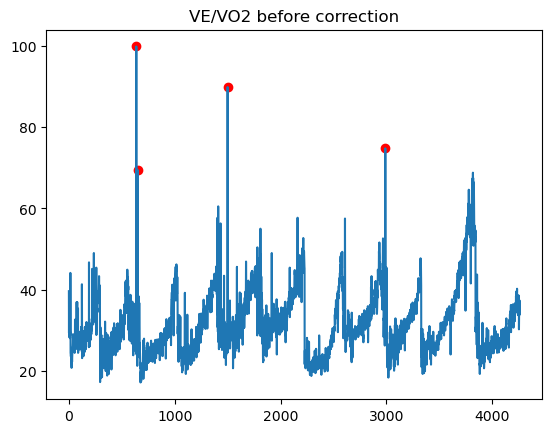

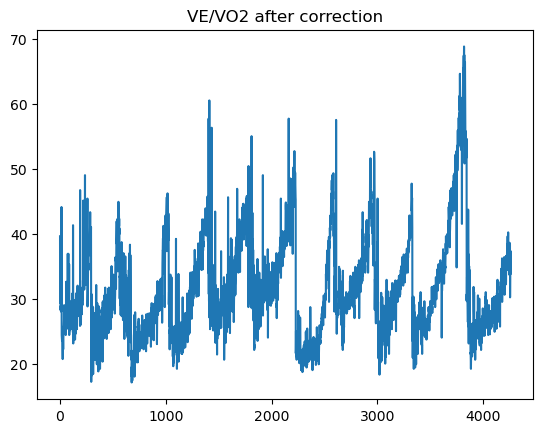

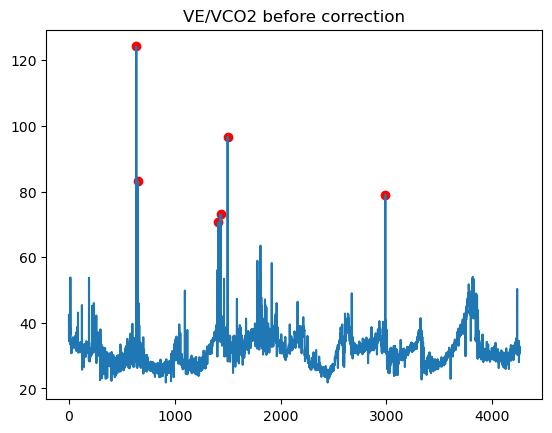

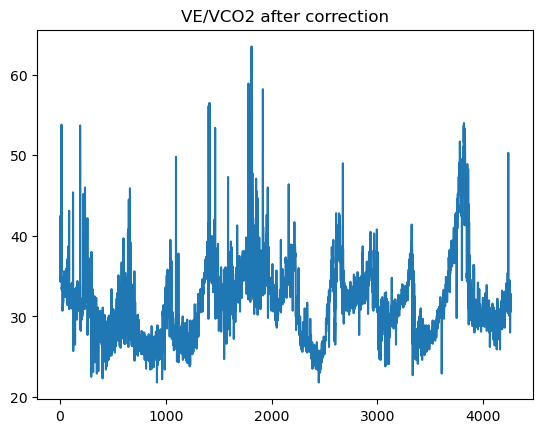

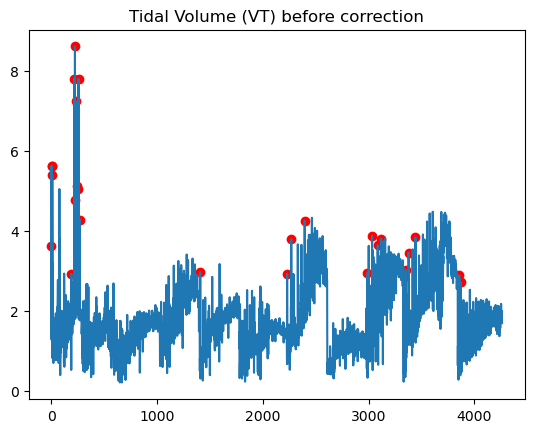

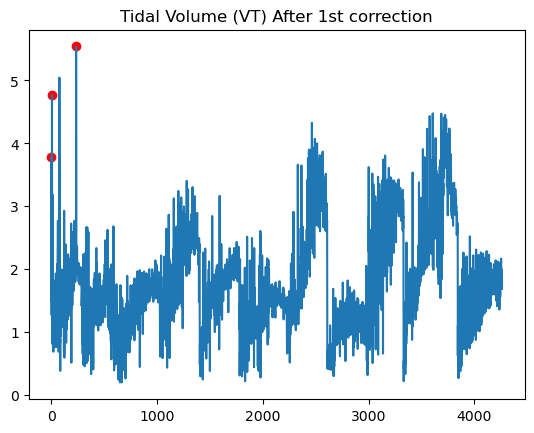

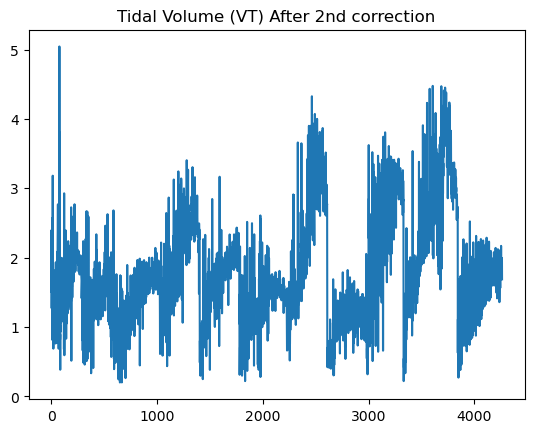

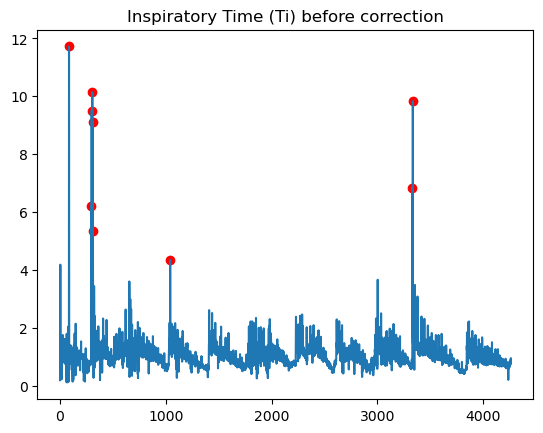

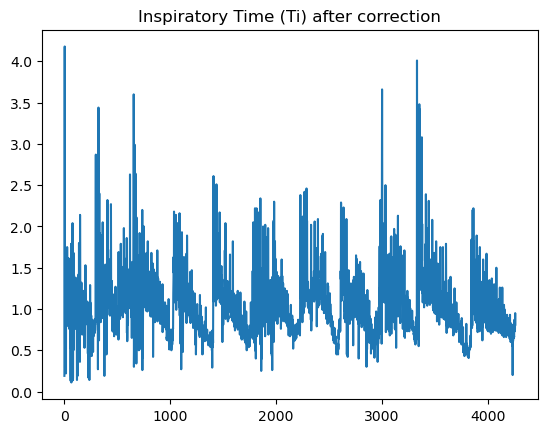

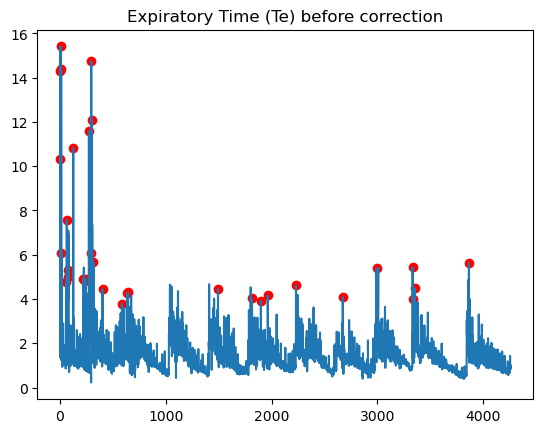

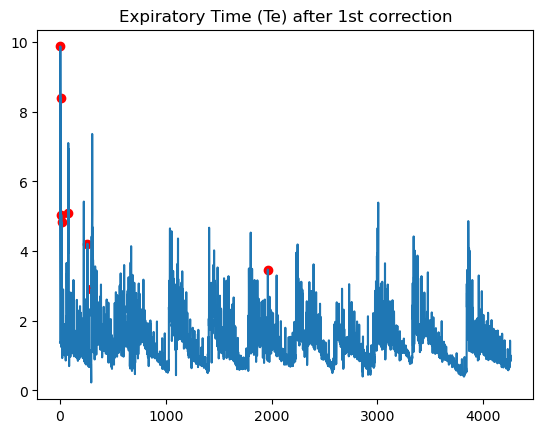

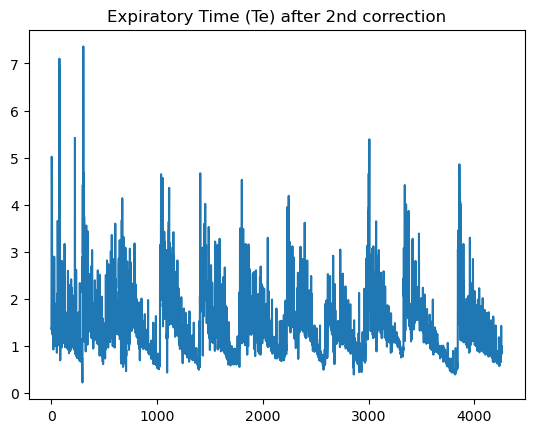

In [200]:
LC_df_edit = copy.deepcopy(LC_df)
LC_df_edit.reset_index(inplace = True)
LC_df_edit.drop(columns = 'index', inplace = True)
LC_df_edit['HR'].replace(0, np.nan, inplace=True)

vevo2_incr = find_large_increments(LC_df_edit['VE/VO2'], 30)
plt.figure()
plt.plot(LC_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, LC_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    LC_df_edit.loc[i, 'VE/VO2'] = LC_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(LC_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')    

vevco2_incr = find_large_increments(LC_df_edit['VE/VCO2'], 30)
plt.figure()
plt.plot(LC_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, LC_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    LC_df_edit.loc[i, 'VE/VCO2'] = LC_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(LC_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

tv_incr = find_large_increments(LC_df_edit['VT'], 2)
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.scatter(tv_incr, LC_df_edit['VT'][tv_incr], color = 'red')
plt.title('Tidal Volume (VT) before correction')
for i in tv_incr:
    LC_df_edit.loc[i, 'VT'] = LC_df_edit.loc[i-1, 'VT']
tv_incra = find_large_increments(LC_df_edit['VT'], 2)
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.scatter(tv_incra, LC_df_edit['VT'][tv_incra], color = 'red')
plt.title('Tidal Volume (VT) After 1st correction')
for i in tv_incra:
    LC_df_edit.loc[i, 'VT'] = LC_df_edit.loc[i-1, 'VT']
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.title('Tidal Volume (VT) After 2nd correction')


ti_incr = find_large_increments(LC_df_edit['Ti'], 2.5)
plt.figure()
plt.plot(LC_df_edit['Ti'])
plt.scatter(ti_incr, LC_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    LC_df_edit.loc[i, 'Ti'] = LC_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(LC_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

te_incr = find_large_increments(LC_df_edit['Te'], 2.5)
plt.figure()
plt.plot(LC_df_edit['Te'])
plt.scatter(te_incr, LC_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    LC_df_edit.loc[i, 'Te'] = LC_df_edit.loc[i-1, 'Te']
plt.figure()
te_incr = find_large_increments(LC_df_edit['Te'], 2.5)
plt.plot(LC_df_edit['Te'])
plt.scatter(te_incr, LC_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) after 1st correction')
for i in te_incr:
    LC_df_edit.loc[i, 'Te'] = LC_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(LC_df_edit['Te'])
plt.title('Expiratory Time (Te) after 2nd correction')


#### Removing participant 6 for being a huge outlier (TEMPORARY DECISION) (Currently disabled)

In [201]:
idxdx = LC_df_edit['Participant'] == 'LC_6'
LC_df_edit = LC_df_edit.loc[-idxdx]


### Exporting the data

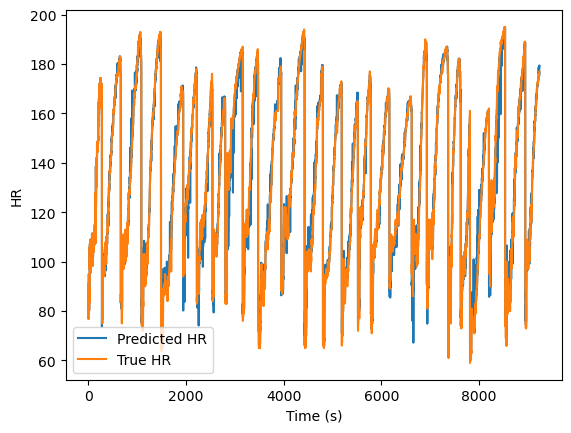

0.9668768768895024
Before filling missing values: 276
After filling missing values: 0


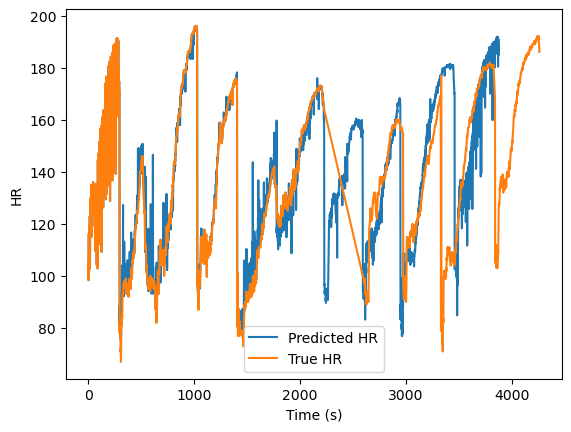

0.9377497973031873
Before filling missing values: 343
After filling missing values: 0


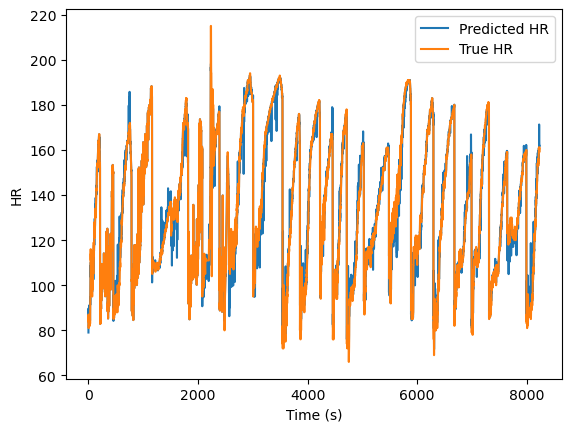

0.9419795487700724
Before filling missing values: 971
After filling missing values: 0


In [202]:
# Split the data into features and target
# train a linear regression model to predict HR
from sklearn.model_selection import train_test_split
# import standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
for df in [Control_df_edit, LC_df_edit, ME_df_edit]:
    missing_start_n = df['HR'].isna().sum()
    df_dropped = df.dropna()
    X = df_dropped.drop(columns = ['HR', 'Participant', 'Phase'])
    y = df_dropped['HR']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_with_nan = model.predict(scaler.transform(df.drop(columns = ['HR', 'Participant', 'Phase'])))
    y_undropped = df['HR'].copy()
    to_fill = y_undropped[y_undropped.isnull()].index
    y_undropped[to_fill] = y_pred_with_nan[to_fill]
    df['HR'] = y_undropped
    #predict HR for the entire dataset
    HR_pred = model.predict(scaler.transform(df.drop(columns = ['HR', 'Participant', 'Phase'])))
    plt.figure()
    # plot predicted values and true values in one plot against index
    plt.plot(HR_pred, label='Predicted HR')
    plt.plot(df['HR'], label='True HR')
    plt.xlabel('Time (s)')
    plt.ylabel('HR')
    plt.legend()
    plt.show()
    # print score
    print(model.score(X_test_scaled, y_test))
    print(f'Before filling missing values: {missing_start_n}')
    print(f'After filling missing values: {df["HR"].isna().sum()}')

In [203]:
for group_name, df_group in zip(['Controls', 'LC', 'ME'], [Control_df_edit, LC_df_edit, ME_df_edit]):     
    df_group.to_csv(f'{group_name}.data', sep=',', index = False)

In [204]:
Co_exercise = Control_df_edit[Control_df_edit['Phase'] == 'EXERCISE']
LC_exercise = LC_df_edit[LC_df_edit['Phase'] == 'EXERCISE']
ME_exercise = ME_df_edit[ME_df_edit['Phase'] == 'EXERCISE']

In [205]:
df_pt1 = {'Controls': 0, 'LC': 0, 'ME': 0}
# take several quantiles of the exercise phase data and store them in a dictionary (0.2, 0.5, 0.8)
for df in [Co_exercise, LC_exercise, ME_exercise]:
    # create a list for each group with the quantiles
    df_pt1[df['Participant'].iloc[0][:-2]] = []
    print(df['Participant'].iloc[0][:-2])
    for i in [0.2, 0.5, 0.8, 0.9]:
        quantile = df.groupby('Participant')['t'].max().quantile(i)
        df_pt1[df['Participant'].iloc[0][:-2]].append(df[df['t'] <= quantile])
        print(quantile)
    print('')

Controls
839.0
960.5
1035.0
1056.0

LC
826.4
932.5
1002.4
1116.0

ME
754.0
985.0
1154.0
1279.5



Controls 0.2 0.8752859773729903
Controls 0.5 0.9127471048285181
Controls 0.8 0.9225083675266711
Controls 0.9 0.9223243012892677
LC 0.2 0.8343992718185994
LC 0.5 0.867018265142566
LC 0.8 0.8731503853297786
LC 0.9 0.8916645553576189
ME 0.2 0.3636151741496939
ME 0.5 0.48839356004150325
ME 0.8 0.5690631939668297
ME 0.9 0.6275054812588692


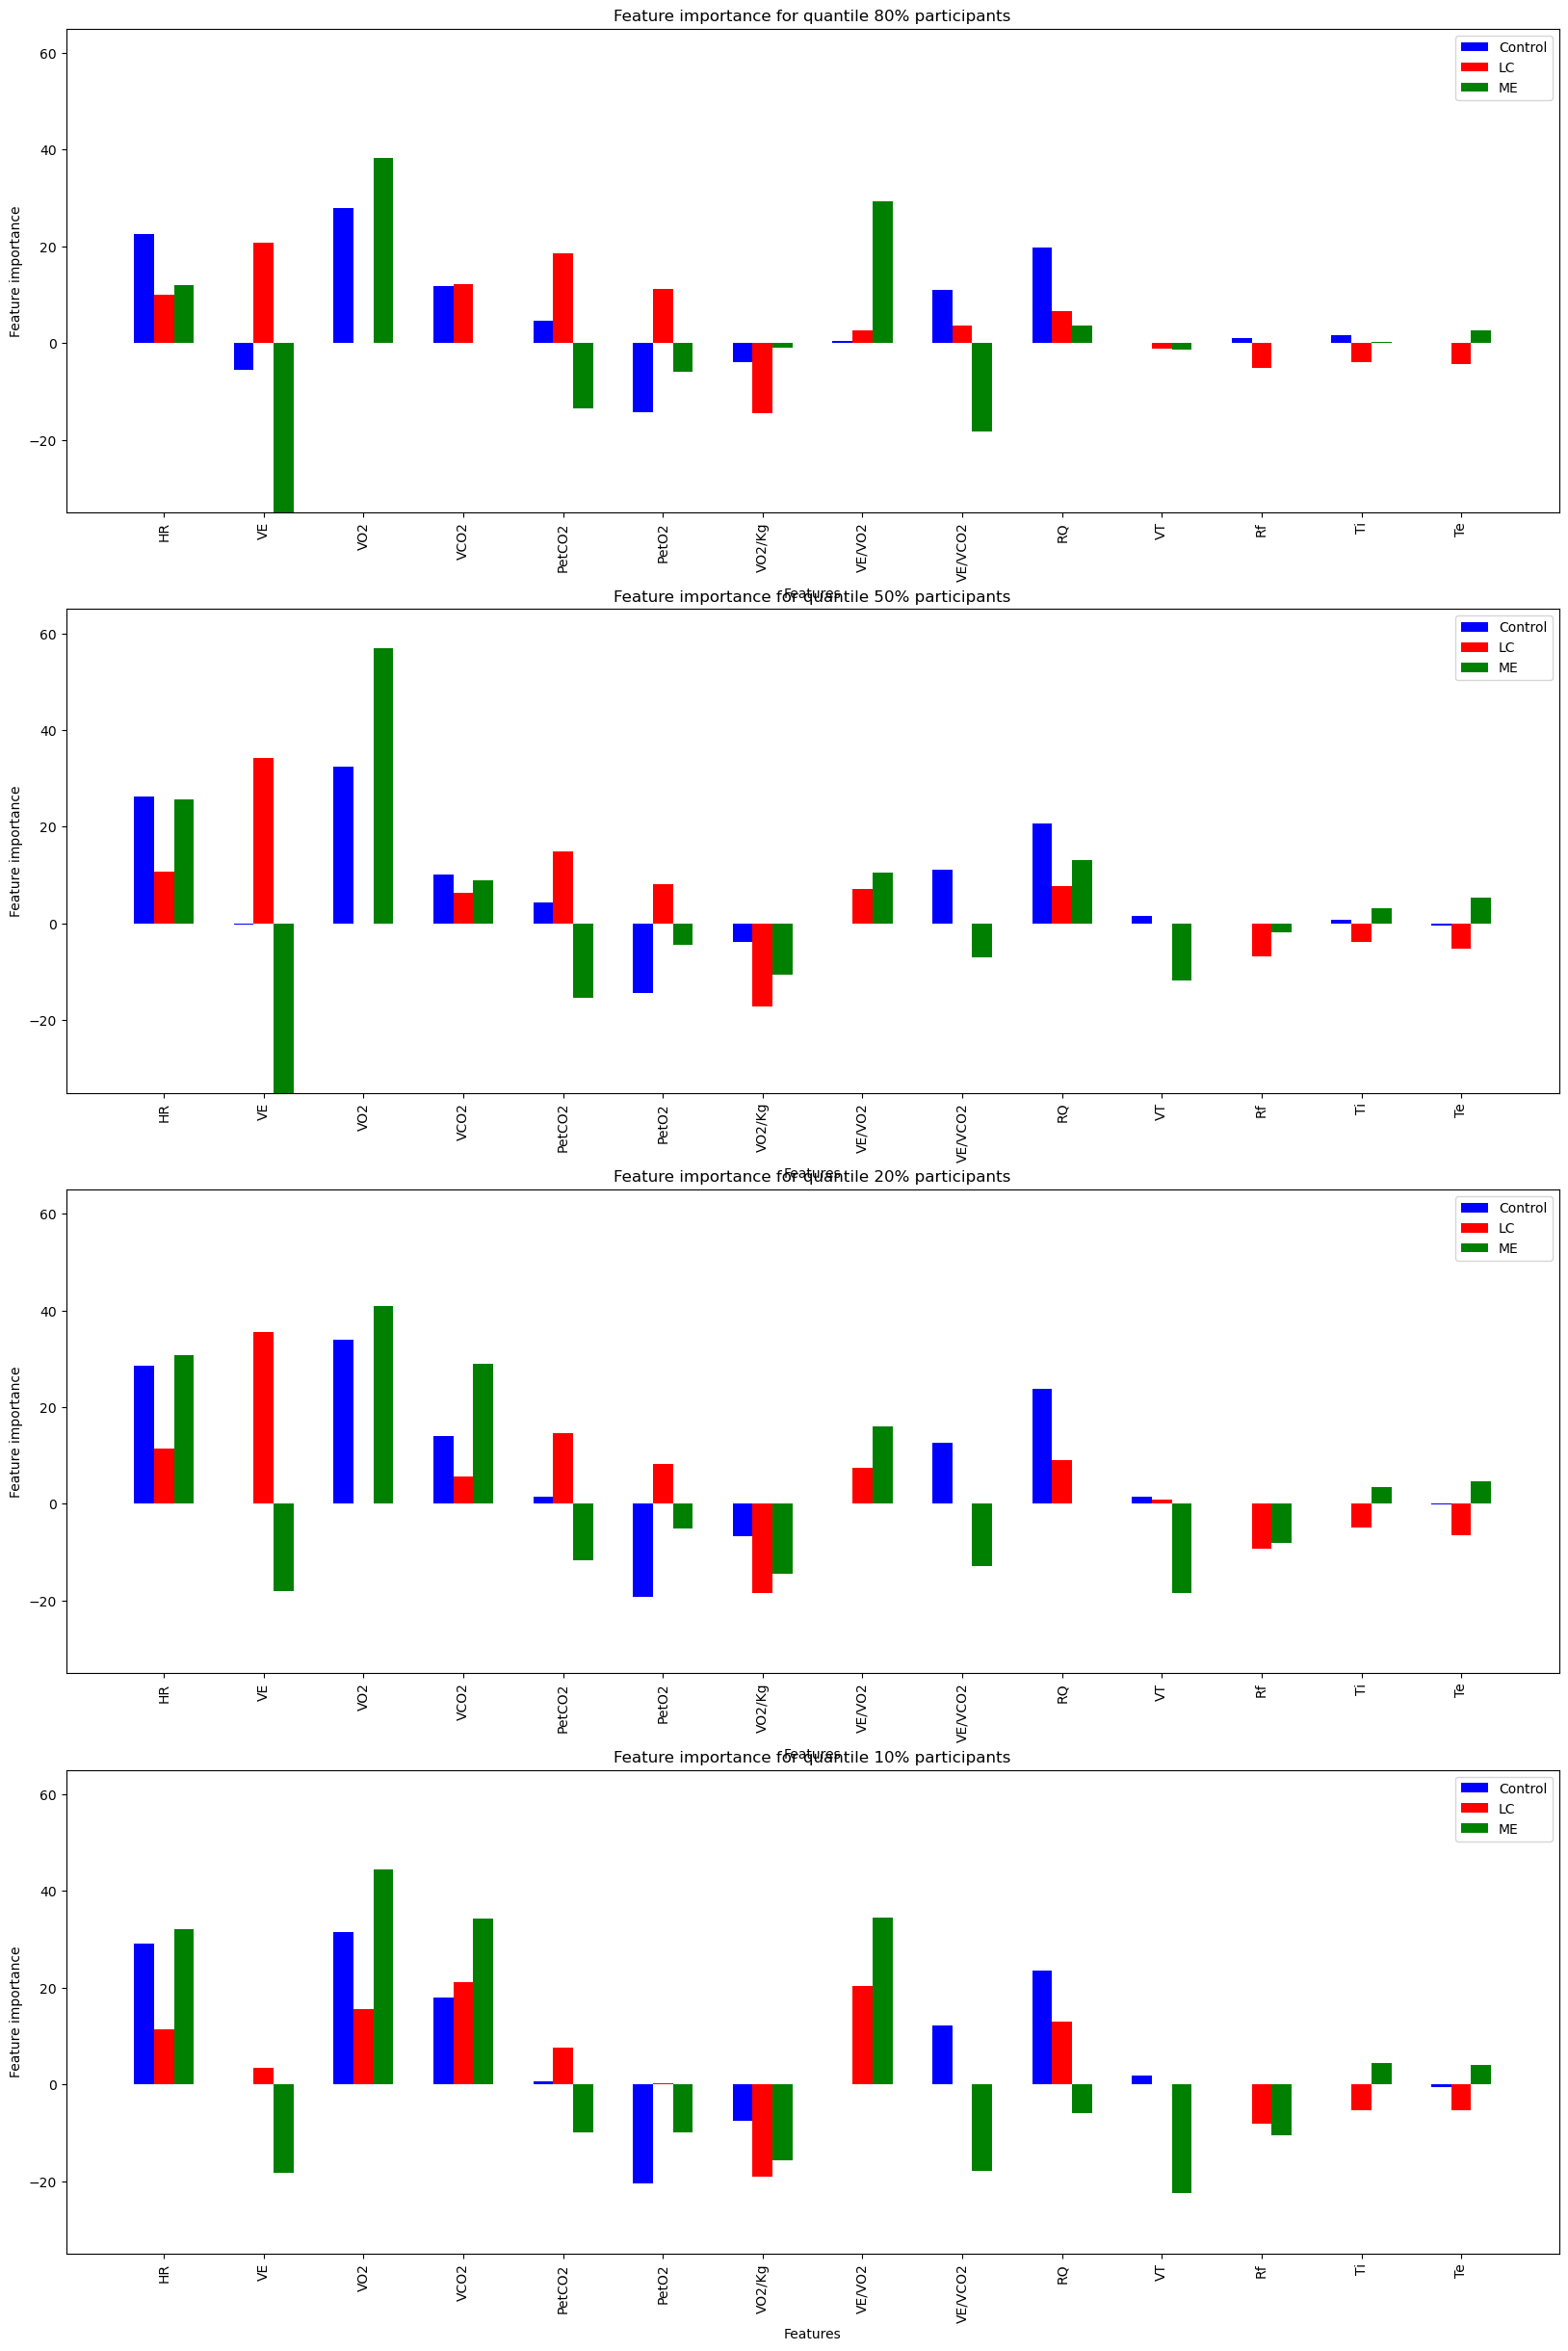

In [206]:
# create lasso regression model for each group and each quantile
# use the power as the target variable
# use the features from the feature importance function
# store the models in a dictionary
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np

# Get all features
all_features = Co_exercise.columns.tolist()
for dropped_feat in ['Power', 'Participant', 'Phase', 't']:
    all_features.remove(dropped_feat)

np.random.seed(42)

models = {'Controls': {}, 'LC': {}, 'ME': {}}
sorted_feature_importance_0_2 = []
sorted_feature_importance_0_5 = []
sorted_feature_importance_0_8 = []
sorted_feature_importance_0_9 = []

for df in [Co_exercise, LC_exercise, ME_exercise]:
    for i in [0.2, 0.5, 0.8, 0.9]:
        df_copy = copy.deepcopy(df)
        df_copy = df_copy[df_copy['t'] <= df.groupby('Participant')['t'].max().quantile(i)]
        df_copy.dropna(inplace=True)
        df_copy.reset_index(inplace=True)

        X = df_copy.drop(columns = ['Power', 'Participant', 'Phase', 't', 'index'])
        y = df_copy['Power']

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        lasso = Lasso(alpha=0.1)
        lasso.fit(X_scaled, y)

        # print sorted feature importance
        feature_importance = dict(zip(X.columns, lasso.coef_))
        # sort the feature importance by the order of all_features
        sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: all_features.index(item[0]))}
        if i == 0.2:
            sorted_feature_importance_0_2.append(sorted_feature_importance)
        elif i == 0.5:
            sorted_feature_importance_0_5.append(sorted_feature_importance)
        elif i == 0.8:
            sorted_feature_importance_0_8.append(sorted_feature_importance)
        elif i == 0.9:
            sorted_feature_importance_0_9.append(sorted_feature_importance)
        models[df['Participant'].iloc[0][:-2]][i] = lasso
        # print the score of the model
        # print the group name, quantile, and score
        print(df['Participant'].iloc[0][:-2], i, lasso.score(X_scaled, y))

# visualize the feature importance of the models in a single bar chart, per sorted_feature_importance list
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 1, figsize=(20, 30))
quantiles = ['80% participants', '50% participants', '20% participants', '10% participants']
for idx, fi in enumerate([sorted_feature_importance_0_2, sorted_feature_importance_0_5, sorted_feature_importance_0_8, sorted_feature_importance_0_9]):
    Control_features = dict(fi[0])
    LC_features = dict(fi[1])
    ME_features = dict(fi[2])

    # sort features by the order of all_features
    Control_features = {k: v for k, v in sorted(Control_features.items(), key=lambda item: all_features.index(item[0]))}
    LC_features = {k: v for k, v in sorted(LC_features.items(), key=lambda item: all_features.index(item[0]))}
    ME_features = {k: v for k, v in sorted(ME_features.items(), key=lambda item: all_features.index(item[0]))}

    Control_features = list(Control_features.values())
    LC_features = list(LC_features.values())
    ME_features = list(ME_features.values())

    x = range(len(all_features))

    axs[idx].bar(x, Control_features, color='blue', width=0.2, label='Control')
    axs[idx].bar([i + 0.2 for i in x], LC_features, color='red', width=0.2, label='LC')
    axs[idx].bar([i + 0.4 for i in x], ME_features, color='green', width=0.2, label='ME')

    axs[idx].set_xticks([i + 0.2 for i in x])
    axs[idx].set_xticklabels(all_features, rotation=90)
    axs[idx].legend()
    axs[idx].set_title(f'Feature importance for quantile {quantiles[idx]}')
    axs[idx].set_xlabel('Features')
    axs[idx].set_ylabel('Feature importance')
    # set a common y-axis height for all subplots
    axs[idx].set_ylim(-35, 65)

plt.show()


HR
VE
VO2
VCO2
PetCO2
PetO2
VO2/Kg
VE/VO2
VE/VCO2
RQ
VT
Rf
Ti
Te


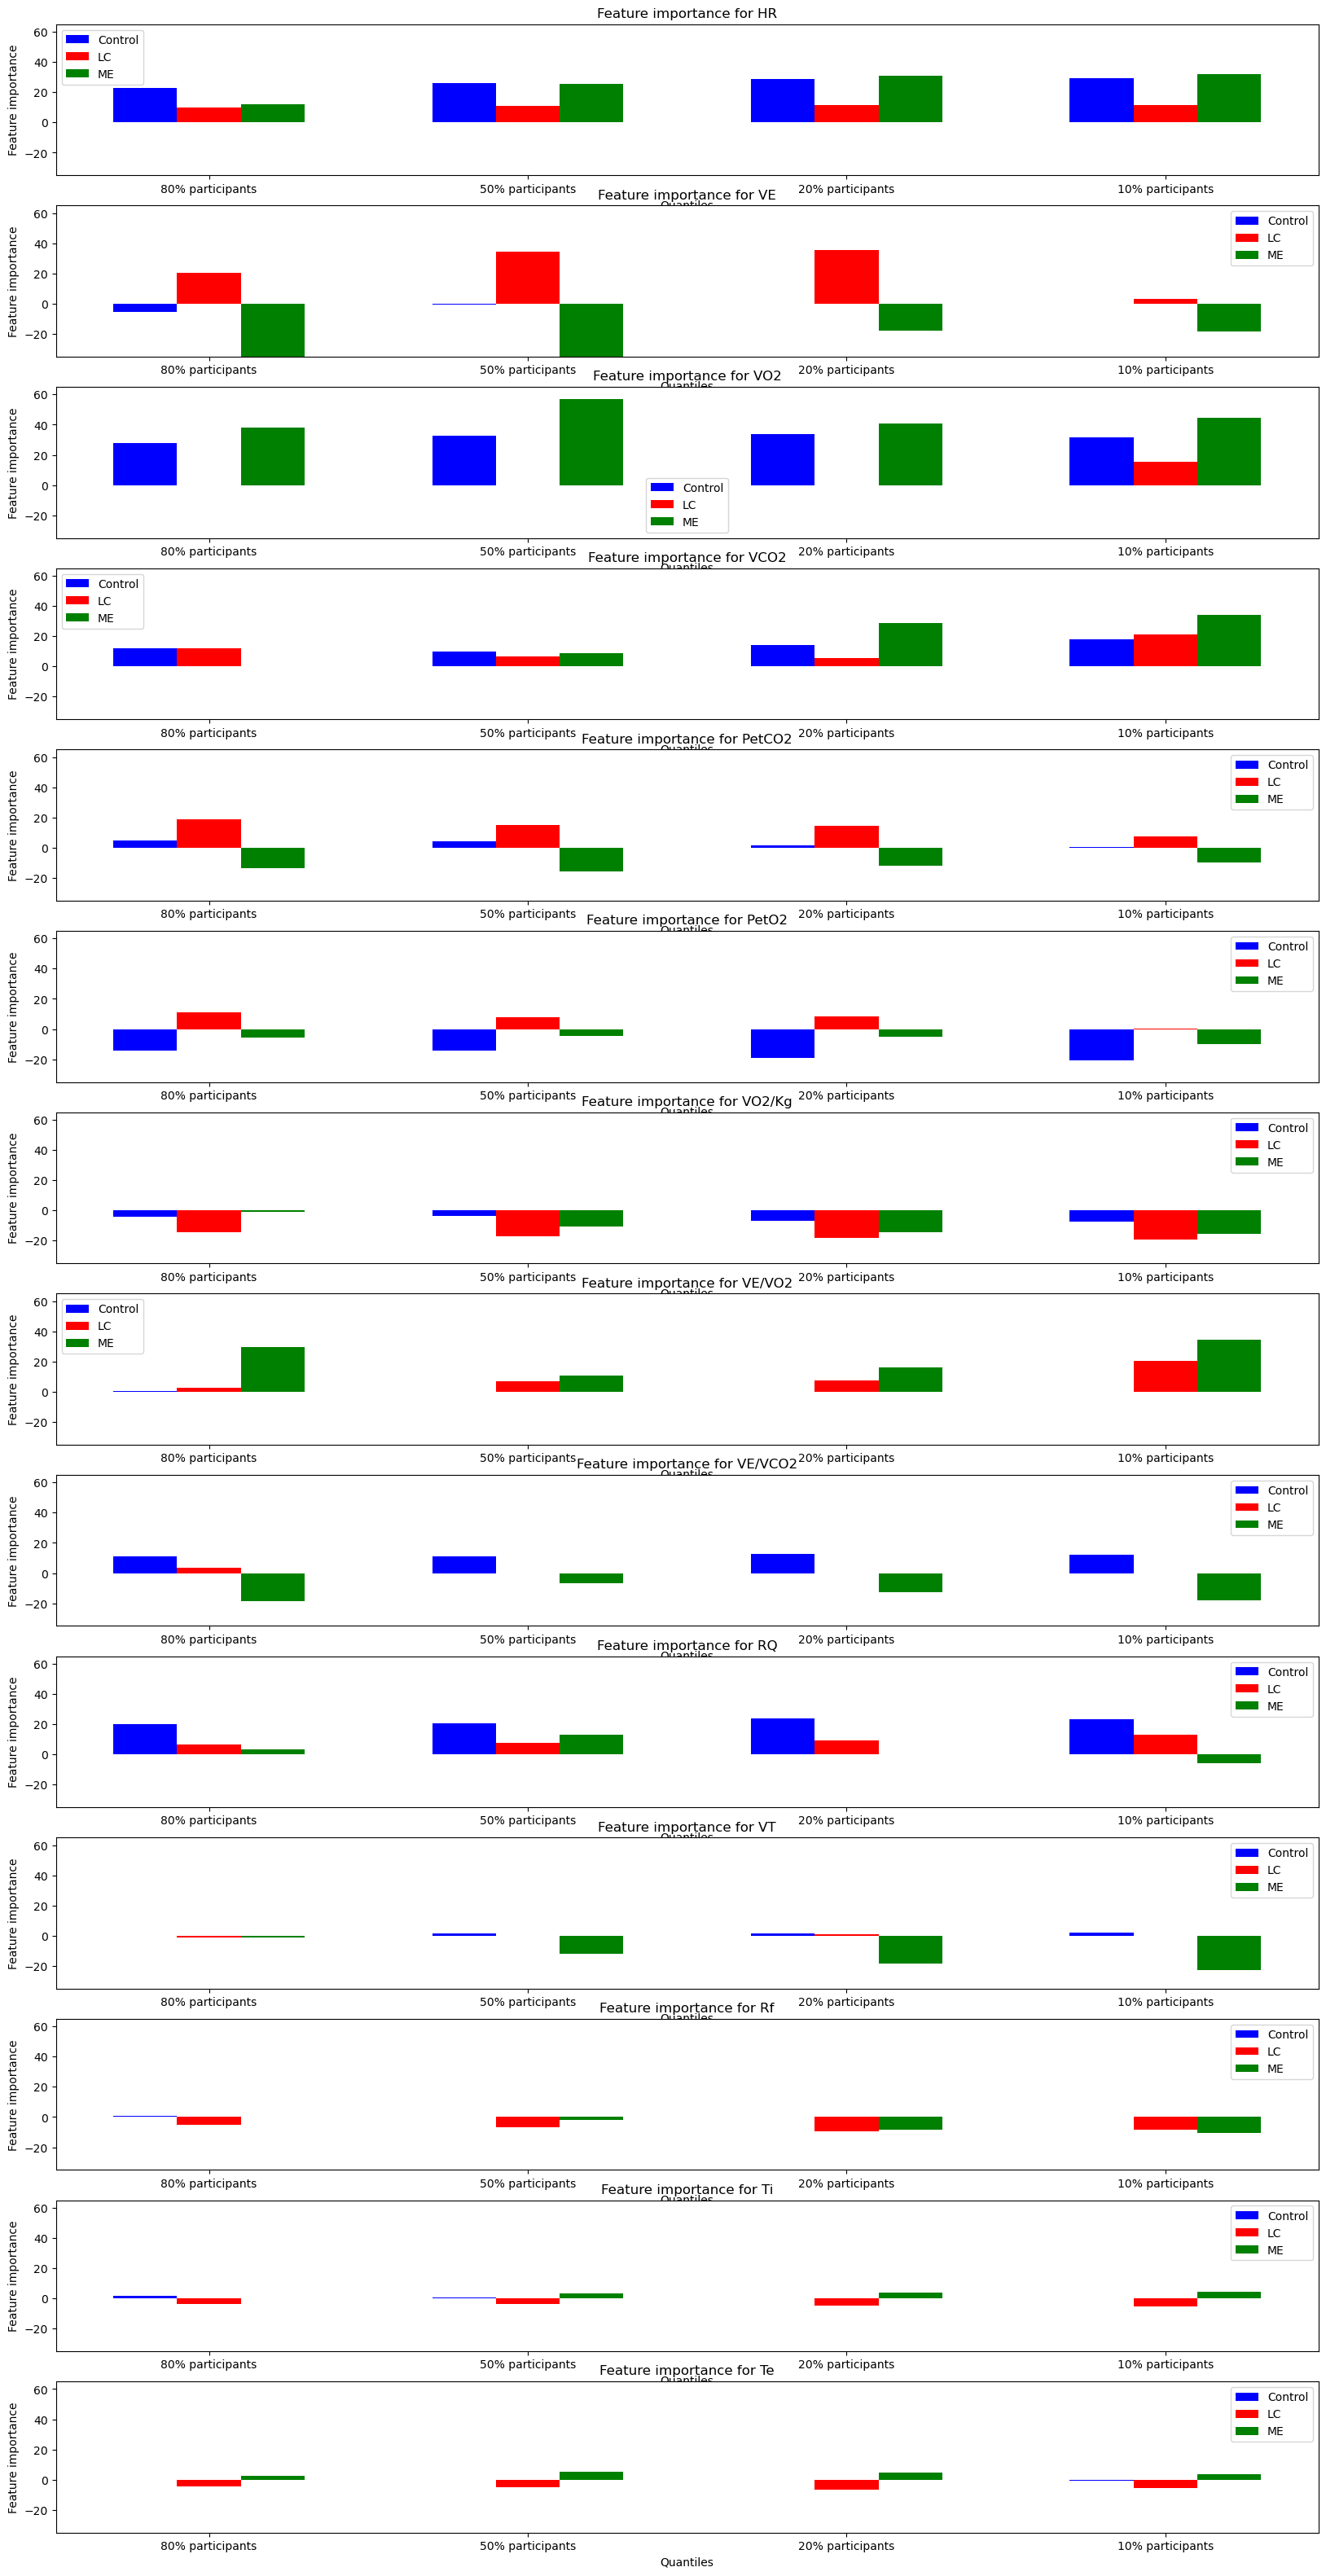

In [207]:
# combine sorted_feature_importance_0_2, sorted_feature_importance_0_5, sorted_feature_importance_0_8, sorted_feature_importance_0_9 into a dataframe
# with columns as features and rows as quantiles
import pandas as pd

df_controls = pd.DataFrame()
df_lc = pd.DataFrame()
df_me = pd.DataFrame()

quantiles_names = ['0_2', '0_5', '0_8', '0_9']
for idx, fi in enumerate([sorted_feature_importance_0_2, sorted_feature_importance_0_5, sorted_feature_importance_0_8, sorted_feature_importance_0_9]):
    Control_features = dict(fi[0])
    LC_features = dict(fi[1])
    ME_features = dict(fi[2])

    # sort features by the order of all_features
    Control_features = {k: v for k, v in sorted(Control_features.items(), key=lambda item: all_features.index(item[0]))}
    LC_features = {k: v for k, v in sorted(LC_features.items(), key=lambda item: all_features.index(item[0]))}
    ME_features = {k: v for k, v in sorted(ME_features.items(), key=lambda item: all_features.index(item[0]))}

    Control_features = list(Control_features.values())
    LC_features = list(LC_features.values())
    ME_features = list(ME_features.values())

    df_controls[f'quantile_{quantiles_names[idx]}'] = Control_features
    df_lc[f'quantile_{quantiles_names[idx]}'] = LC_features
    df_me[f'quantile_{quantiles_names[idx]}'] = ME_features

# set the index of the dataframes to all_features
df_controls.index = all_features
df_lc.index = all_features
df_me.index = all_features

# visualize the feature importance, by creating 1 subplot per feature, with 3 sets of 3 bars (one group of bars per quantile, one bar per group)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(all_features), 1, figsize=(20, 40))

for idx, feature in enumerate(all_features):
    print(feature)
    Control_features = [sorted_feature_importance_0_2[0][feature], sorted_feature_importance_0_5[0][feature], sorted_feature_importance_0_8[0][feature], sorted_feature_importance_0_9[0][feature]]
    LC_features = [sorted_feature_importance_0_2[1][feature], sorted_feature_importance_0_5[1][feature], sorted_feature_importance_0_8[1][feature], sorted_feature_importance_0_9[1][feature]]
    ME_features = [sorted_feature_importance_0_2[2][feature], sorted_feature_importance_0_5[2][feature], sorted_feature_importance_0_8[2][feature], sorted_feature_importance_0_9[2][feature]]
    x = range(4)

    axs[idx].bar(x, Control_features, color='blue', width=0.2, label='Control')
    axs[idx].bar([i + 0.2 for i in x], LC_features, color='red', width=0.2, label='LC')
    axs[idx].bar([i + 0.4 for i in x], ME_features, color='green', width=0.2, label='ME')

    axs[idx].set_xticks([i + 0.2 for i in x])
    axs[idx].set_xticklabels(quantiles)
    axs[idx].legend()
    axs[idx].set_title(f'Feature importance for {feature}')
    axs[idx].set_xlabel('Quantiles')
    axs[idx].set_ylabel('Feature importance')
    # set a common y-axis height for all subplots
    axs[idx].set_ylim(-35, 65)
